In [1]:
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from tqdm import tqdm
from hyppo.ksample import KSample
from hyppo._utils import gaussian

from joblib import Parallel, delayed

from graspologic.simulations import rdpg
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.align import SeedlessProcrustes, SignFlips

## Data generating functions

In [ ]:
def equal(n):
    X = np.random.uniform(.2, .7, size=(n, 1))
    Y = np.random.uniform(.2, .7, size=(n, 1))
    
    return X, Y

def linear(n):
    X = np.random.uniform(.2, .7, size=(n, 1))
    Y = X + 0.1
    
    return X, Y

def nonlinear(n):
    X = np.random.uniform(.2, .7, size=(n, 1))
    b = np.random.beta(.2, .2, size=(n, 1))
    Y = 0.5 * b + 0.2
    
    return X, Y

## Running simulations

In [ ]:
def hypothesis_test(X1, X2):
    tests = [KSample('Dcorr'), KSample('MGC')]
    X1_flipped = SignFlips('median').fit_transform(X1, X2)     
    
    pvals = []
    for test in tests:
        res = test.test(X1_flipped, X2, auto=False)
        pvals.append(res[1])
        
    return pvals

def run(data_func, n):
    X, Y = data_func(n)
    A = rdpg(X)
    B = rdpg(Y)
    
    ase = AdjacencySpectralEmbed(n_components=1, diag_aug=True, check_lcc=False)
    Xhat = ase.fit_transform(A)
    Yhat = ase.fit_transform(B)
    
    pvals = hypothesis_test(Xhat, Yhat)
    return [*pvals, n, data_func.__name__]

In [ ]:
ns = np.linspace(20, 150, 14).astype(int)
datasets = [equal, linear, nonlinear]

args = list(product(ns, datasets))

In [ ]:
repeats = 1000

reses = []
for arg in tqdm(args):
    n, dataset = arg
    res = Parallel(-1, verbose=0)(delayed(run)(dataset, n) for _ in range(repeats))
    reses.extend(res)

In [ ]:
cols = ["DCorr", "MGC", "n", "dataset"]

df = pd.DataFrame(reses, columns=cols)

df.to_csv("./results/figure1.csv", index=False)

## Plotting

In [2]:
# Comment below to use computed instead of precomputed results

df = pd.read_csv("./results/figure1.csv")

Text(0, 0.5, 'Power')

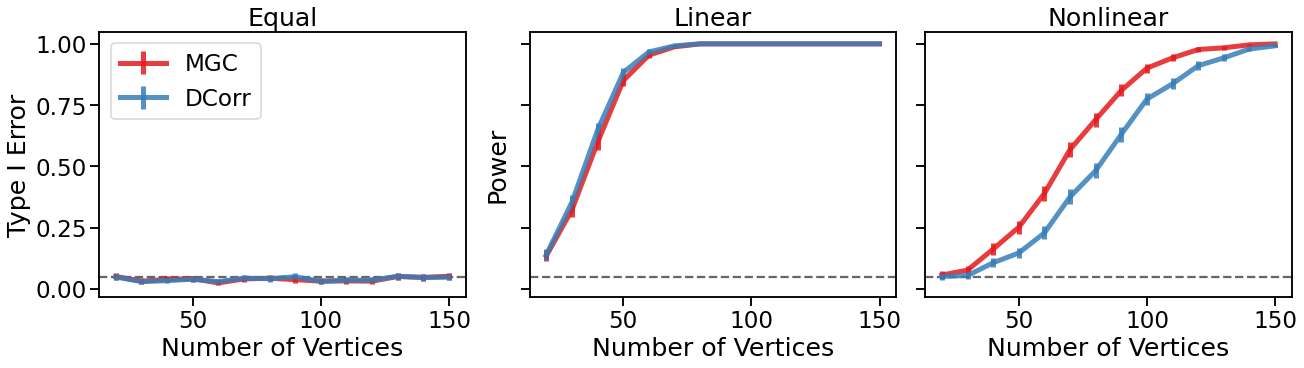

In [3]:
sns.set_context("talk", font_scale=1.4)

titles = ["Equal", "Linear", "Nonlinear"]
algo_titles = ["MGC", "DCorr", ]
colors = ["#e41a1c", "#377eb8"]

ns = np.linspace(20, 150, 14).astype(int)

fig, axes = plt.subplots(ncols=3, figsize=(18, 5), constrained_layout=True, sharex=True, sharey=True)

for idx, dataset in enumerate(titles):
    axes[idx].axhline(0.05, ls="--", c="k", alpha=0.6)

    tmp_df = df[df.dataset == dataset.lower()]

    for jdx, algo in enumerate(algo_titles):
        powers = []
        errs = []

        for n in ns:
            power = np.mean(tmp_df[tmp_df.n == n][algo].values <= 0.05)
            err = 1.96 * np.sqrt(power * (1 - power) / 1000) #1000 = num reps

            powers.append(power)
            errs.append(err)

        axes[idx].errorbar(x = ns, y=powers, yerr=errs, label=algo_titles[jdx], c=colors[jdx], alpha=0.85, lw=5)

    axes[idx].set_xticks([50, 100, 150])
    axes[idx].set_xlabel("Number of Vertices")
    axes[idx].set_title(titles[idx])

axes[0].set_xlim(*(13.5, 156.5))

axes[0].legend(loc="upper left")
axes[0].set_ylabel("Type I Error")
axes[1].set_ylabel("Power", labelpad=20)

In [4]:
fig.savefig("./figures/figure1.pdf", dpi=300, bbox_inches="tight")
fig.savefig("./figures/figure1.png", dpi=300, bbox_inches="tight")